In [41]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc, confusion_matrix
from astropy.table import Table, Column
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
df = pd.read_csv("dataset.csv")
print(df.shape)
df.head()

#It is important to note that every feature included in this dataset is categorical, which provides its own set of 
#challenges. In order to fit models using these features, they must be converted into a useable, numeric form. I will
#be converting them into both integers (as is used by the most popular kernel for this dataset) and into indicator 
#variables (a more classic statistical approach).

(149, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [43]:
df['class'].value_counts()

#While the data is technically imbalanced towards edible mushrooms, it isnt by a significant amount. Throughout
#the course of this analysis I will not only be tracking accuracy score, but also recall and precision scores.

e    128
p     21
Name: class, dtype: int64

In [9]:
df.isnull().sum().sum()

0

In [44]:
#Conversion of categorical features into indicator variables.
df_dum = pd.DataFrame()
for col in df.columns:
    dum = pd.get_dummies(df[col])
    for dcol in dum.columns:
        name = col +"_"+ dcol
        df_dum[name] = dum[dcol]
print(df_dum.shape)

df_int = pd.DataFrame()
le = LabelEncoder()
for col in df.columns:
    df_int[col] = le.fit_transform( df[col])
df_int.head()

(149, 61)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,3,1,1,1,3,0,0,1,2,...,1,0,0,0,0,0,1,0,2,4
1,0,3,1,3,1,0,0,0,0,2,...,1,0,0,0,0,0,1,1,1,1
2,0,0,1,2,1,1,0,0,0,3,...,1,0,0,0,0,0,1,1,1,2
3,1,3,2,2,1,3,0,0,1,3,...,1,0,0,0,0,0,1,0,2,4
4,0,3,1,0,0,2,0,1,0,2,...,1,0,0,0,0,0,0,1,0,1


In [45]:
df_dum.head()

,class_e,class_p,cap-shape_b,cap-shape_f,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_s,cap-surface_y,cap-color_g,...,population_a,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_m,habitat_p,habitat_u
0,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
2,1,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,1,0,0,0,0,1,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0


In [46]:
#Summary of Preprocess:
#Dataframes:

#Categorical Features : df
#Dummy Features : df_dum
#Integer Features : df_int

#I/O versions:

#Categorical Features : X
#Categorical Response: y
#Dummy Features : Xd
#Dummy Response : yd
#Scaled, Dummy Features : Xds, scalerd

X = df.iloc[:,1:]
y = df.iloc[:,0]
Xd = df_dum.iloc[:,2:]
yd = df_dum.iloc[:,0:2]
Xi = df_int.iloc[:,1:]
yi = df_int.iloc[:,0]
scalerd = StandardScaler()
Xds = scalerd.fit_transform(Xd)
scaleri = StandardScaler()
Xis = scaleri.fit_transform(Xi)

In [47]:
#Initial Model Fitting

def d_method( X, y, model, random_state = 0, k = 5 ):
    # Fits a categorical model and outputs a cross-validation result of:
    # Accuracy, Recall, Precision, and the model thats fit last.
    # The data is train/test split and shuffled systematically
    kf = ShuffleSplit( n_splits = k )
    ac = np.zeros( k ); re = np.zeros( k ); pr = np.zeros( k )
    i = 0
    for train_index, test_index in kf.split(X):
        t_model = clone(model)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        t_model.fit( X_train, y_train )
        y_pred = t_model.predict( X_test )
        ac[i] = accuracy_score( y_test, y_pred )
        re[i] = recall_score( y_test, y_pred )
        pr[i] = precision_score( y_test, y_pred )
        i = i+1
    return( ac, re, pr, t_model )

In [48]:
def d_conf( X_test, y_test, t_model, p=0.5 ):
    # Creates a confusion matrix
    # Using a test set of data and a trained model
    ypro = t_model.predict_proba(X_test)
    yp = ypro[:,1] >= p
    cm = confusion_matrix(y_test, yp)
    return(cm)

In [49]:
def d_conf_l( X_test, y_test, t_model):
    # The same as d_conf only removing the theshold of class selection
    yp = t_model.predict(X_test)
    cm = confusion_matrix(y_test, yp)
    return(cm)

In [50]:
def d_roc( X_test, y_test, t_model, points=100):
    # Generates a plot that describes the changes in
    #   Accuracy, recall, precision scores as the threshold
    #   For classification changes.
    #   Using a test set of data and a trained model
    ac_p=np.zeros(points); re_p=np.zeros(points); pr_p=np.zeros(points); 
    for i in np.arange(points):
        ypro = t_model.predict_proba(X_test)
        yp = ypro[:,1] >= (i/points)
        ac_p[i] = accuracy_score( y_test, yp )
        re_p[i] = recall_score( y_test, yp )
        pr_p[i] = precision_score( y_test, yp )
    t = np.arange(points)/points
    plt.plot(t, ac_p, label='accuracy score')
    plt.plot(t, re_p, label = 'recall score')
    plt.plot(t, pr_p, label = 'precision score')
    plt.legend()
    plt.show()

In [51]:
def d_summary(X, y, model, random_state = 0,k=5,X_test=None,y_test=None,p=0.5,points=100):
    # Runs the d_method, d_conf, and d_roc on a model and dataset.
    ac, re, pr, t_model = d_method( X, y, model )
    print( "Accuracy Score =  ", ac, " Mean = ", ac.mean() )
    print( "Recall Score =    ", re, " Mean = ", re.mean() )
    print( "Precision Score = ", pr, " Mean = ", pr.mean() )
    if X_test is None:
        X_test = X
    if y_test is None:
        y_test = y
    cm = d_conf( X_test, y_test, t_model, p)
    print("Confusion Matrix:")
    print(cm)
    d_roc( X_test, y_test, t_model, points)

Logistic Regression Result: 


Accuracy Score =   [ 1.  1.  1.  1.  1.]  Mean =  1.0
Recall Score =     [ 1.  1.  1.  1.  1.]  Mean =  1.0
Precision Score =  [ 1.  1.  1.  1.  1.]  Mean =  1.0
Confusion Matrix:
[[128   0]
 [  0  21]]


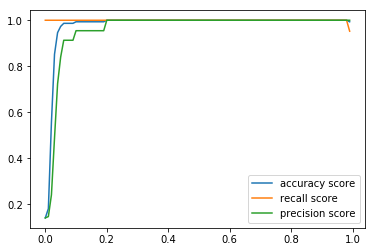

Bagging Classifier Result: 


Accuracy Score =   [ 1.  1.  1.  1.  1.]  Mean =  1.0
Recall Score =     [ 1.  0.  1.  1.  1.]  Mean =  0.8
Precision Score =  [ 1.  0.  1.  1.  1.]  Mean =  0.8
Confusion Matrix:
[[128   0]
 [  0  21]]


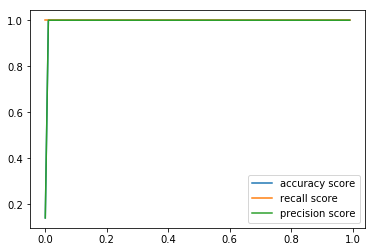

KNeighborsClassifier Result: 


Accuracy Score =   [ 1.  1.  1.  1.  1.]  Mean =  1.0
Recall Score =     [ 1.  1.  1.  1.  0.]  Mean =  0.8
Precision Score =  [ 1.  1.  1.  1.  0.]  Mean =  0.8
Confusion Matrix:
[[128   0]
 [  0  21]]


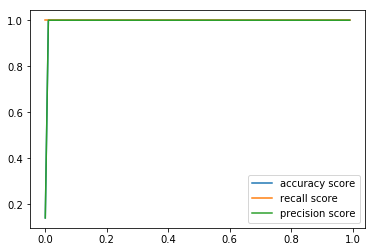

GaussianNB Result: 


Accuracy Score =   [ 1.  1.  1.  1.  1.]  Mean =  1.0
Recall Score =     [ 1.  1.  1.  1.  1.]  Mean =  1.0
Precision Score =  [ 1.  1.  1.  1.  1.]  Mean =  1.0
Confusion Matrix:
[[128   0]
 [  0  21]]


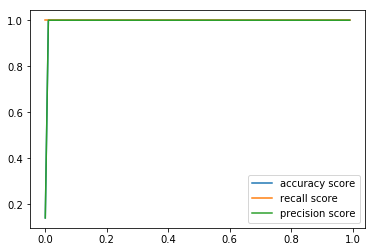

RandomForest Classifier Result: 


Accuracy Score =   [ 1.  1.  1.  1.  1.]  Mean =  1.0
Recall Score =     [ 1.  0.  1.  1.  1.]  Mean =  0.8
Precision Score =  [ 1.  0.  1.  1.  1.]  Mean =  0.8
Confusion Matrix:
[[128   0]
 [  0  21]]


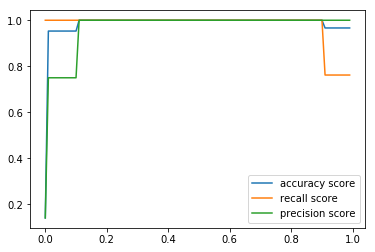

DecisionTree Classifier Result: 


Accuracy Score =   [ 1.  1.  1.  1.  1.]  Mean =  1.0
Recall Score =     [ 1.  0.  1.  1.  1.]  Mean =  0.8
Precision Score =  [ 1.  0.  1.  1.  1.]  Mean =  0.8
Confusion Matrix:
[[128   0]
 [  0  21]]


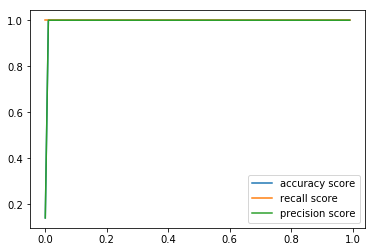

In [52]:
print("Logistic Regression Result: \n\n")
d_summary( Xds, yi, LogisticRegression() )

print("Bagging Classifier Result: \n\n")
d_summary( Xds, yi, BaggingClassifier() )

print("KNeighborsClassifier Result: \n\n")
d_summary( Xds, yi, KNeighborsClassifier() )

print("GaussianNB Result: \n\n")
d_summary( Xds, yi, GaussianNB() )

print("RandomForest Classifier Result: \n\n")
d_summary( Xds, yi, RandomForestClassifier() )

print("DecisionTree Classifier Result: \n\n")
d_summary( Xds, yi, DecisionTreeClassifier() )

